# Comprehensive Model Analysis

This notebook automatically loads all inference outputs from `../../outputs/` and provides a comprehensive statistical analysis, including:
- **Coverage**: Percentage of samples where the model made a prediction (not -1).
- **Pseudo-Label Accuracy**: Accuracy calculated only on the samples where the model made a prediction.
- **Overall Accuracy**: Standard accuracy where abstaining (-1) is considered incorrect.
- **Model Agreement**: Analysis of overlap and disagreement between models on the same dataset.

In [6]:
import pandas as pd
import numpy as np
import glob
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Configuration
OUTPUT_DIR = "../../outputs"
FILENAME_PATTERN = re.compile(r"(.+)-(.+)-(.+)\.csv") # [dataset]-[model]-[split].csv


## 1. Data Loading

In [7]:
def load_all_outputs(output_dir):
    all_files = glob.glob(os.path.join(output_dir, "*.csv"))
    dfs = []
    
    print(f"Found {len(all_files)} CSV files in {output_dir}")
    
    for fpath in all_files:
        fname = os.path.basename(fpath)
        match = FILENAME_PATTERN.match(fname)
        
        if match:
            dataset_name, model_name, split_name = match.groups()
            try:
                df = pd.read_csv(fpath)
                # Verify columns
                required_cols = {'sample_id', 'prediction', 'confidence', 'ground_truth'}
                if not required_cols.issubset(df.columns):
                    print(f"Warning: Skipping {fname} - missing columns. Found: {df.columns.tolist()}")
                    continue
                    
                df['dataset'] = dataset_name
                df['model'] = model_name
                df['split'] = split_name
                df['source_file'] = fname
                dfs.append(df)
                print(f"Loaded {fname}: {len(df)} samples")
            except Exception as e:
                print(f"Error loading {fname}: {e}")
        else:
            print(f"Warning: {fname} does not match naming convention [dataset]-[model]-[split].csv")
            
    if not dfs:
        print("No valid dataframes loaded!")
        return pd.DataFrame()
        
    return pd.concat(dfs, ignore_index=True)

full_df = load_all_outputs(OUTPUT_DIR)
full_df.head()

Found 2 CSV files in ../../outputs
Loaded imagenet_streaming-mobilenet_v3_large-val.csv: 50000 samples
Loaded imagenet_streaming-swin_t-val.csv: 50000 samples


,sample_id,prediction,confidence,ground_truth,dataset,model,split,source_file
0,imagenet_streaming_validation_91,91,0.9240,91,imagenet_streaming,mobilenet_v3_large,val,imagenet_streaming-mobilenet_v3_large-val.csv
1,imagenet_streaming_validation_171,180,0.1319,171,imagenet_streaming,mobilenet_v3_large,val,imagenet_streaming-mobilenet_v3_large-val.csv
2,imagenet_streaming_validation_980,980,0.4969,980,imagenet_streaming,mobilenet_v3_large,val,imagenet_streaming-mobilenet_v3_large-val.csv
3,imagenet_streaming_validation_218,218,0.7626,218,imagenet_streaming,mobilenet_v3_large,val,imagenet_streaming-mobilenet_v3_large-val.csv
4,imagenet_streaming_validation_19,19,0.8153,19,imagenet_streaming,mobilenet_v3_large,val,imagenet_streaming-mobilenet_v3_large-val.csv


## 2. Statistical Analysis

In [8]:
if not full_df.empty:
    summary_stats = []

    # Group by Experiment identifiers
    grouped = full_df.groupby(['dataset', 'model', 'split'])

    for (dset, model, split), group in grouped:
        total = len(group)
        
        # Coverage: Predictions that are NOT -1
        valid_preds = group[group['prediction'] != -1]
        n_valid = len(valid_preds)
        coverage = n_valid / total if total > 0 else 0
        
        # Pseudo-Label Accuracy: Accuracy within covered samples
        if n_valid > 0:
            pl_acc = accuracy_score(valid_preds['ground_truth'], valid_preds['prediction'])
        else:
            pl_acc = 0.0
            
        # Overall Accuracy: Accuracy on ALL samples (treating -1 as wrong)
        # Note: Scikit-learn will treat -1 as just another class label if we blindly pass it.
        # But here we want -1 to be ALWAYS wrong (unless GT is -1, which shouldn't happen).
        overall_acc = accuracy_score(group['ground_truth'], group['prediction'])
        
        summary_stats.append({
            'Dataset': dset,
            'Model': model,
            'Split': split,
            'Total Samples': total,
            'Coverage': coverage,
            'PL Accuracy': pl_acc,
            'Overall Accuracy': overall_acc
        })
        
    stats_df = pd.DataFrame(summary_stats)
    # Styling for better readability
    display(stats_df.style.format({
        'Coverage': '{:.2%}',
        'PL Accuracy': '{:.2%}',
        'Overall Accuracy': '{:.2%}'
    }))
else:
    print("No data to analyze.")

,Dataset,Model,Split,Total Samples,Coverage,PL Accuracy,Overall Accuracy
0,imagenet_streaming,mobilenet_v3_large,val,50000,100.00%,75.32%,75.32%
1,imagenet_streaming,swin_t,val,50000,100.00%,81.08%,81.08%


## 3. Confusion Matrices

In [9]:
if not full_df.empty:
    datasets = full_df['dataset'].unique()
    
    for dset in datasets:
        dset_df = full_df[full_df['dataset'] == dset]
        models = dset_df['model'].unique()
        
        for model in models:
            subset = dset_df[dset_df['model'] == model]
            
            # Filter out -1 predictions for Confusion Matrix interpretation usually,
            # OR keep them to see abstentions. Let's keep them but note it.
            y_true = subset['ground_truth']
            y_pred = subset['prediction']
            
            labels = sorted(list(set(y_true) | set(y_pred)))
            
            if len(labels) > 20:
                print(f"Skipping CM for {dset}-{model}: Too many classes ({len(labels)})")
                continue
                
            cm = confusion_matrix(y_true, y_pred, labels=labels)
            
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
            plt.title(f"Confusion Matrix: {dset} - {model}")
            plt.xlabel('Predicted')
            plt.ylabel('Ground Truth')
            plt.show()

Skipping CM for imagenet_streaming-mobilenet_v3_large: Too many classes (1000)
Skipping CM for imagenet_streaming-swin_t: Too many classes (1000)


## 4. Model Agreement Analysis


--- Agreement Analysis: imagenet_streaming ---
comparing mobilenet_v3_large vs swin_t (N=1000) 

Both Correct: 36143 (72.3%)
Only mobilenet_v3_large: 1517 (3.0%)
Only swin_t: 4398 (8.8%)
Both Wrong: 7942 (15.9%)


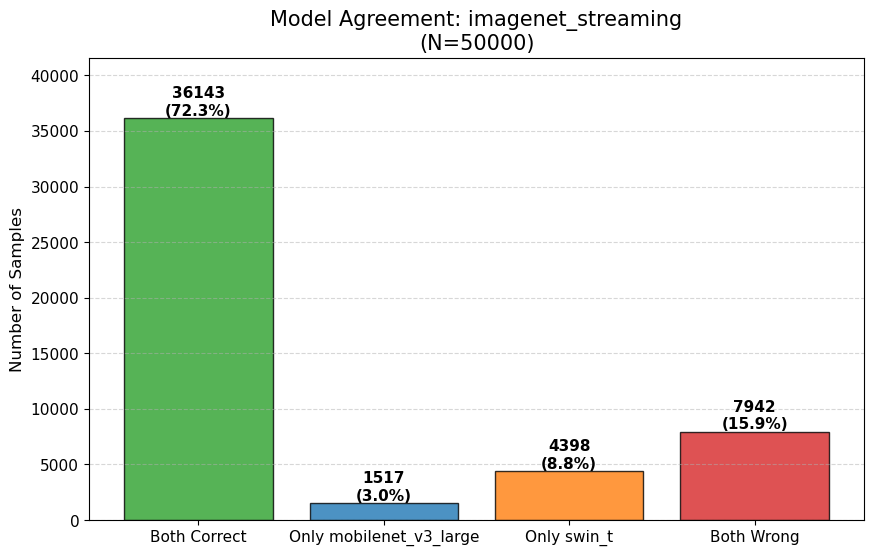

In [10]:
# Iterate over datasets
for dset in full_df['dataset'].unique():
    dset_df = full_df[full_df['dataset'] == dset]
    models = sorted(dset_df['model'].unique())
    
    if len(models) < 2:
        continue
        
    print(f"\n--- Agreement Analysis: {dset} ---")
    
    # Pairwise comparison (taking first two for plotting)
    m1, m2 = models[0], models[1]
    
    df1 = dset_df[dset_df['model'] == m1].set_index('sample_id')
    df2 = dset_df[dset_df['model'] == m2].set_index('sample_id')
    
    # Intersect indices
    common_ids = df1.index.intersection(df2.index)
    
    if len(common_ids) == 0:
        print(f"No overlapping samples between {m1} and {m2}")
        continue
        
    sub1 = df1.loc[common_ids]
    sub2 = df2.loc[common_ids]
    
    # Correctness masks
    # Note: Using Overall Accuracy definition (prediction == ground_truth)
    c1 = sub1['prediction'] == sub1['ground_truth']
    c2 = sub2['prediction'] == sub2['ground_truth']
    
    only_1 = (c1 & ~c2).sum()
    only_2 = (~c1 & c2).sum()
    both = (c1 & c2).sum()
    neither = (~c1 & ~c2).sum()
    
    print(f"comparing {m1} vs {m2} (N={len(common_ids)}) \n")
    
    # Percentage calculations
    total = len(sub1)
    counts = [both, only_1, only_2, neither]
    percentages = [c/total for c in counts]
    categories = ['Both Correct', f'Only {m1}', f'Only {m2}', 'Both Wrong']
    colors = ['#2ca02c', '#1f77b4', '#ff7f0e', '#d62728']  # Green, Blue, Orange, Red
    
    # Print stats
    for cat, count, pct in zip(categories, counts, percentages):
        print(f"{cat}: {count} ({pct:.1%})")
    
    plt.figure(figsize=(10, 6))
    
    # Bar Chart
    bars = plt.bar(categories, counts, color=colors, alpha=0.8, edgecolor='black')
    
    # Add counts and percentages above bars
    for bar, count, pct in zip(bars, counts, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{count}\n({pct:.1%})',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.title(f"Model Agreement: {dset}\n(N={total})", fontsize=15)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.ylim(0, max(counts) * 1.15) # Add space for labels
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.show()